In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Text(0.5, 1.0, 'Imagem Original')

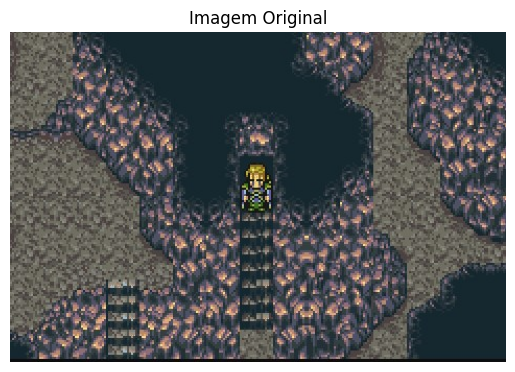

In [3]:
dicionario = {
    'Planicie': 'FFVI\\Maps\\planicie.jpg',
    'Planicie2': 'FFVI\\Maps\\planicie2.jpg',
    'Planicie3': 'FFVI\\Maps\\planicie3.jpg',
    'CavernaExt': 'FFVI\\Maps\\caverna_exterior.jpg',
    'CavernaInt': 'FFVI\\Maps\\caverna_interior.jpg',
    'CavernaInt2': 'FFVI\\Maps\\caverna_interior2.jpg',
    'CavernaInt3': 'FFVI\\Maps\\caverna_interior3.jpg',
}

escolha = 'CavernaInt' 
original_image = Image.open(dicionario[escolha])
cv2_img = np.array(original_image)
plt.imshow(cv2_img)
plt.axis('off')
plt.title('Imagem Original')

Text(0.5, 1.0, 'Imagem em Escala de Cinza')

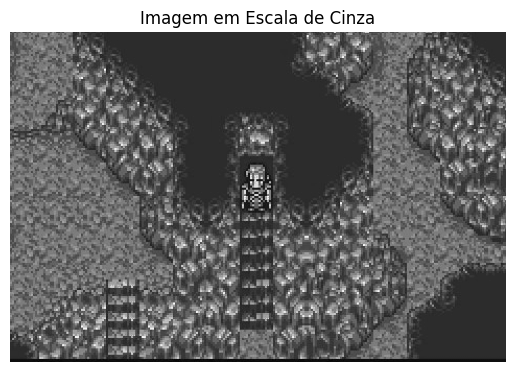

In [134]:
gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('Imagem em Escala de Cinza')

True

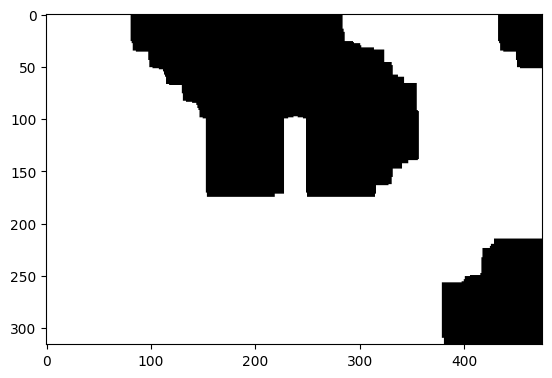

In [135]:
edges_closed = cv2.Canny(gray, 10, 1)
# Definir um kernel para operações de morfologia
kernel = np.ones((10,10), np.uint8)
# smoothed_image = cv2.GaussianBlur(edges_closed, (9, 9), 0)
# smoothed_image = cv2.GaussianBlur(smoothed_image, (9, 9), 0)
# smoothed_image = cv2.GaussianBlur(smoothed_image, (9, 9), 0)
# smoothed_image = cv2.GaussianBlur(smoothed_image, (9, 9), 0)
# smoothed_image = cv2.GaussianBlur(smoothed_image, (9, 9), 0)
# Fechar as falhas nos traços
edges_closed = cv2.morphologyEx(edges_closed, cv2.MORPH_CLOSE, kernel)
# Erodir as linhas para reduzi-las de volta ao tamanho original ou próximo dele
edges_closed = cv2.erode(edges_closed, kernel, iterations=4)

edges_binary = cv2.threshold(edges_closed, 0, 255, cv2.THRESH_BINARY)[1]
plt.imshow(edges_binary, cmap='grey')
cv2.imwrite(f'results/{escolha}_contorno.jpeg', edges_binary)

In [9]:
def plot_hsv(hist_h, hist_s, hist_v):
    # Criar a grade de subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plotar o primeiro gráfico
    axs[0].plot(hist_h)
    axs[0].set_title('H')

    # Plotar o segundo gráfico
    axs[1].plot(hist_s)
    axs[1].set_title('S')

    # Plotar o terceiro gráfico
    axs[2].plot(hist_v)
    axs[2].set_title('V')

    # Ajustar layout para evitar sobreposição de rótulos
    plt.tight_layout()

    # Mostrar os gráficos
    plt.show()

In [73]:
def plot_diff(hist):
    # Calcular a primeira derivada do histograma
    primeira_derivada = np.diff(hist.squeeze())
    primeira_derivada = np.convolve(primeira_derivada.squeeze(), np.ones(10)/10, mode='valid')

    # Calcular a segunda derivada do histograma
    segunda_derivada = np.diff(primeira_derivada)
    segunda_derivada = np.convolve(segunda_derivada.squeeze(), np.ones(10)/10, mode='valid')

    # Plotar os gráficos
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(hist)
    plt.title('Histograma Original')

    plt.subplot(1, 3, 2)
    plt.plot(primeira_derivada)
    plt.title('Primeira Derivada')

    plt.subplot(1, 3, 3)
    plt.plot(segunda_derivada)
    plt.title('Segunda Derivada')

    plt.tight_layout()
    plt.show()

In [74]:
def find_path(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Definir o intervalo de cores para o chão (mais restrito)
    # Calcular o histograma da matiz (H)
    hist_h = cv2.calcHist([hsv], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [256], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [256], [0, 256])

    hist_h = np.convolve(hist_h.squeeze(), np.array([0, 1, 1, 1, 1, 1, 0]) / 5 , mode='valid')
    hist_s = np.convolve(hist_s.squeeze(), np.ones(5)/5, mode='valid')
    hist_v = np.convolve(hist_v.squeeze(), np.ones(5)/5, mode='valid')
    # Encontrar o valor de matiz (H) mais comum
    valor_h_comum = np.argmax(hist_h)
    valor_s_comum = np.argmax(hist_s)
    valor_v_comum = np.argmax(hist_v)
    # Definir os limites do intervalo de cor baseados no valor de matiz (H) mais comum
    tolerancia_h = 50  # Define a tolerância para a cor mais comum
    tolerancia_s = 50  # Define a tolerância para a cor mais comum
    tolerancia_v = 50  # Define a tolerância para a cor mais comum
    h_min = max(0, valor_h_comum - tolerancia_h)
    h_max = min(255, valor_h_comum + tolerancia_h)
    s_min = max(0, valor_s_comum - tolerancia_s)
    s_max = min(255, valor_s_comum + tolerancia_s)
    v_min = max(0, valor_v_comum - tolerancia_v)
    v_max = min(255, valor_v_comum + tolerancia_v)

    imagem_blur = cv2.GaussianBlur(hsv, (13, 13), 0)
    imagem_blur = cv2.GaussianBlur(imagem_blur, (11, 11), 0)
    imagem_blur = cv2.GaussianBlur(imagem_blur, (7, 7), 0)
    imagem_blur = cv2.GaussianBlur(imagem_blur, (5, 5), 0)
    imagem_blur = cv2.GaussianBlur(imagem_blur, (3, 3), 0)

    lowerb = np.array([h_min, s_min, v_min])
    upperb = np.array([h_max, s_max, v_max])

    # Criar a máscara usando os limites do intervalo de cor
    mascara = cv2.inRange(hsv, lowerb, upperb)

    kernel = np.ones((3,3), np.uint8)
    imagem_dilatada = cv2.dilate(mascara, kernel, iterations=8)

    kernel = np.ones((3,3), np.uint8)
    imagem_erodida = cv2.erode(imagem_dilatada, kernel, iterations=10)
    imagem_invertida = cv2.bitwise_not(imagem_erodida)

    contorno = cv2.bitwise_and(cv2_img, cv2_img, mask=imagem_invertida)
    #plot_hsv(hist_h, hist_s, hist_v)
    plot_diff(hist_h)
    # plot_diff(hist_s)
    # plot_diff(hist_v)
    #print("H:",valor_h_comum*360/255,"S:",valor_s_comum*100/255,"V:",valor_h_comum*100/255)
    plt.figure()
    plt.imshow(contorno, cmap="grey")
    plt.axis('off')

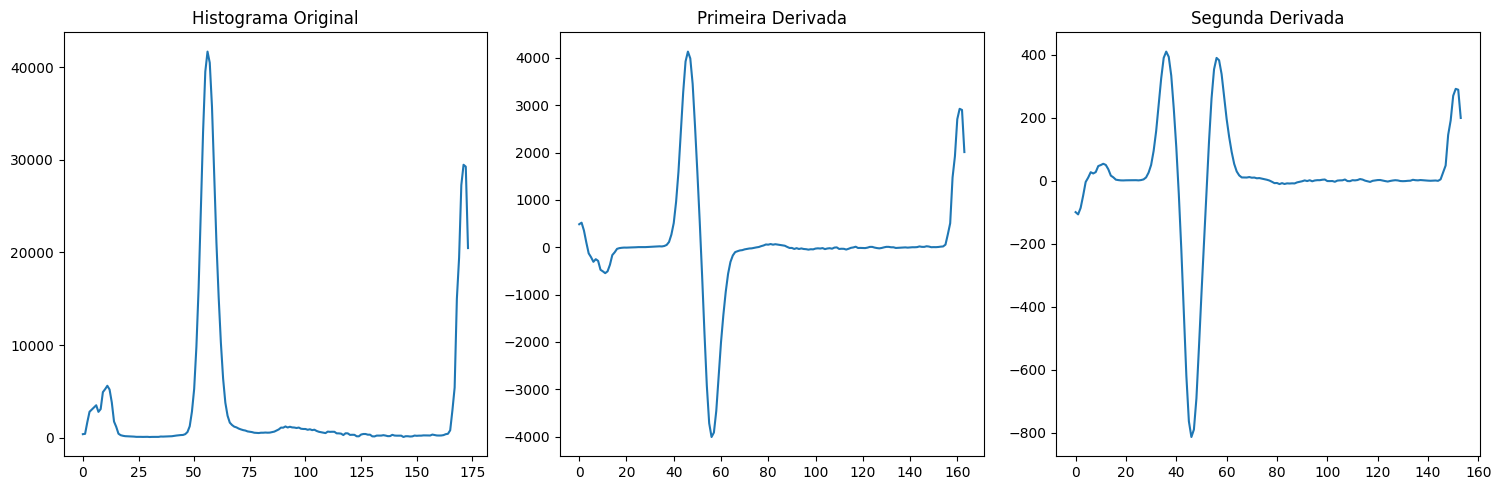

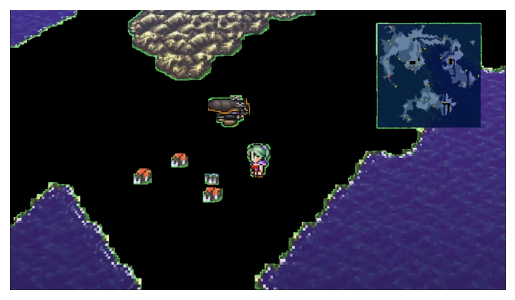

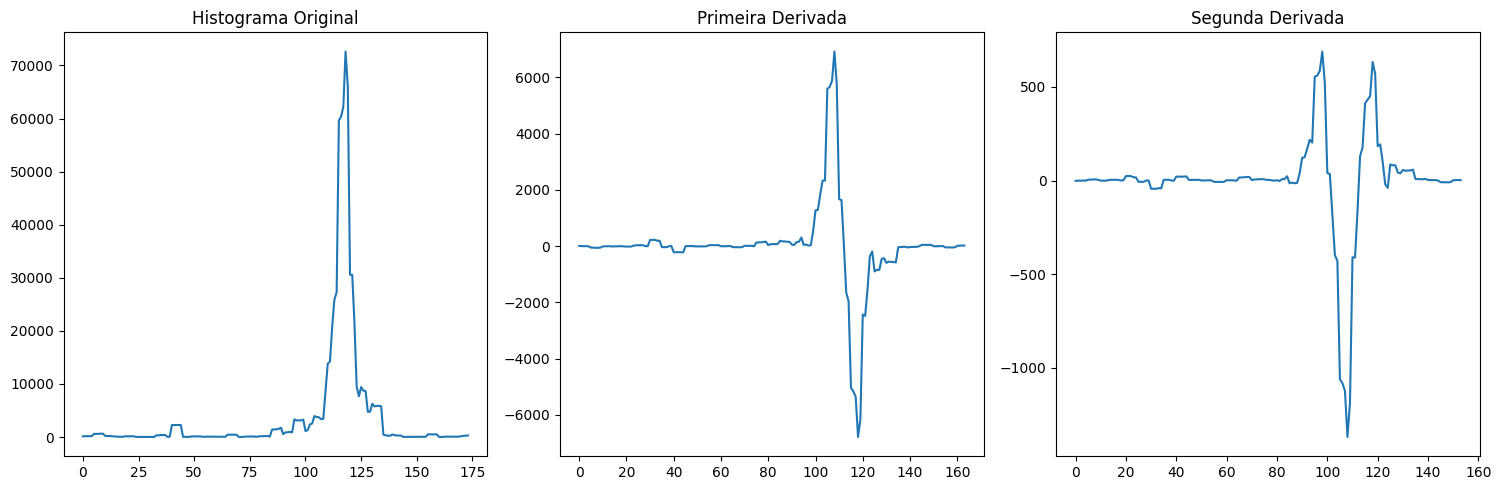

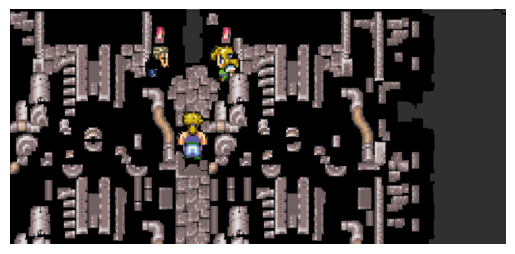

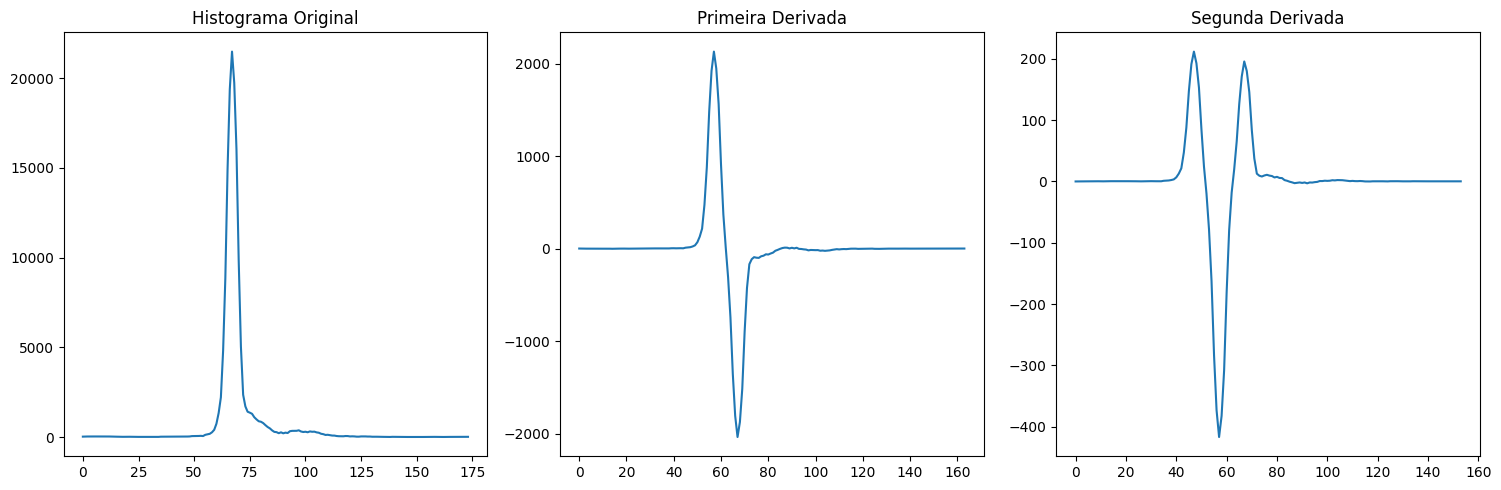

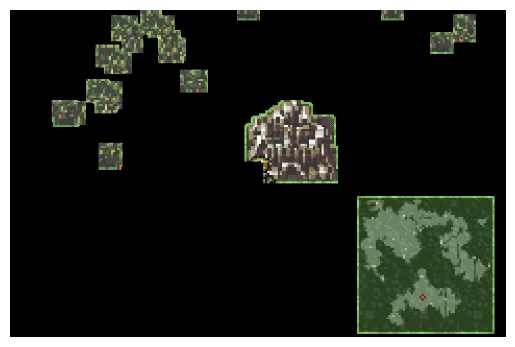

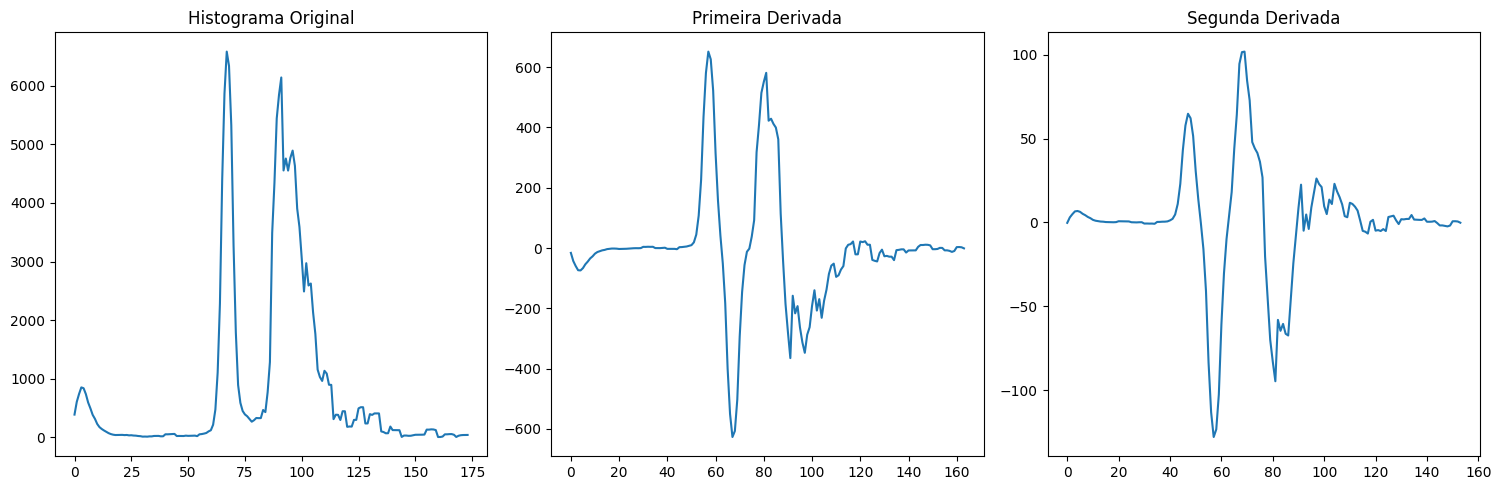

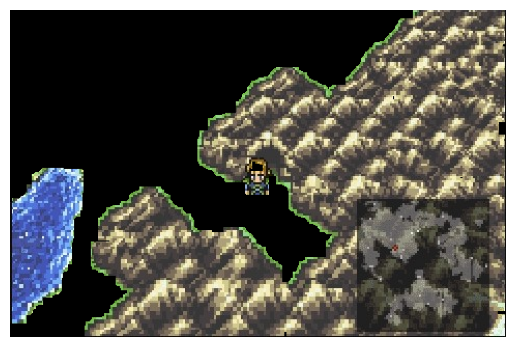

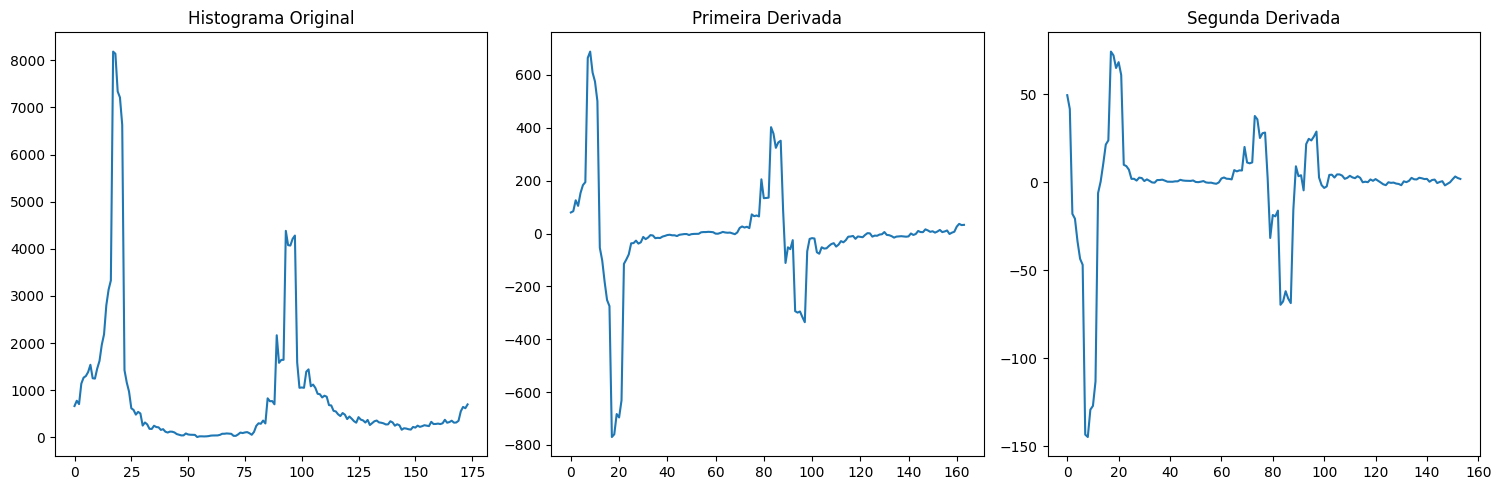

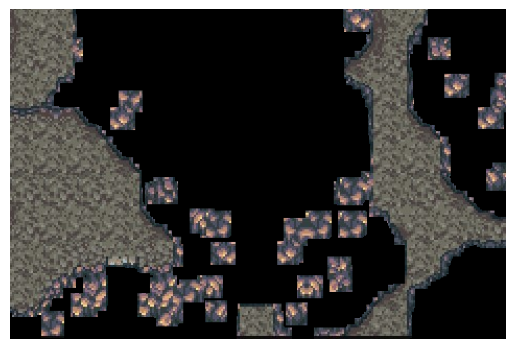

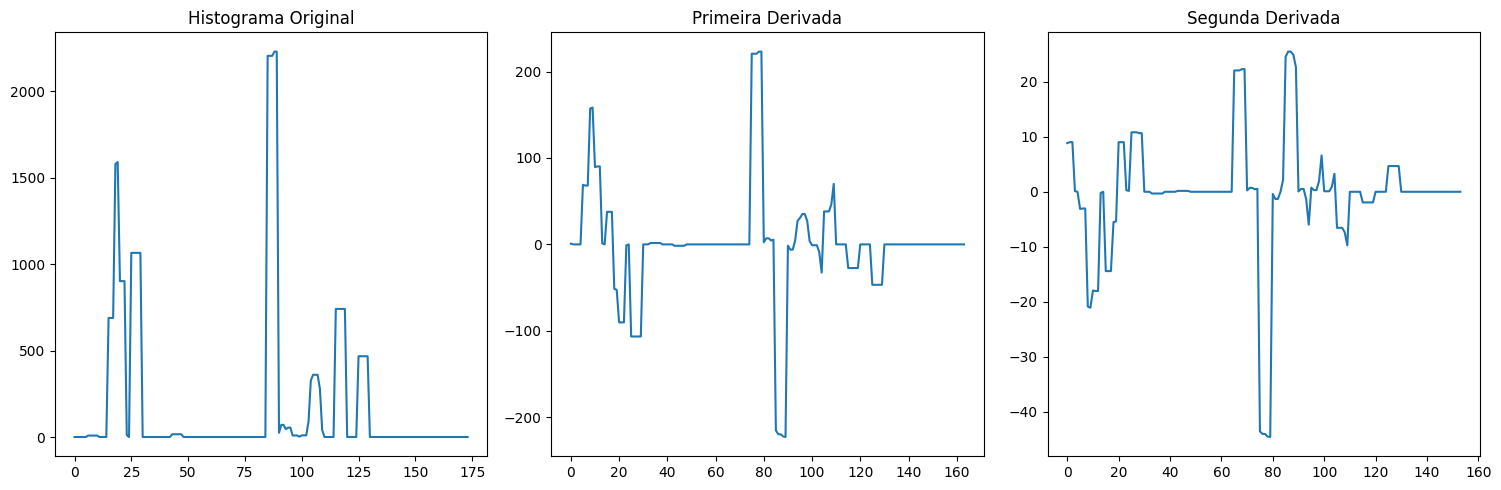

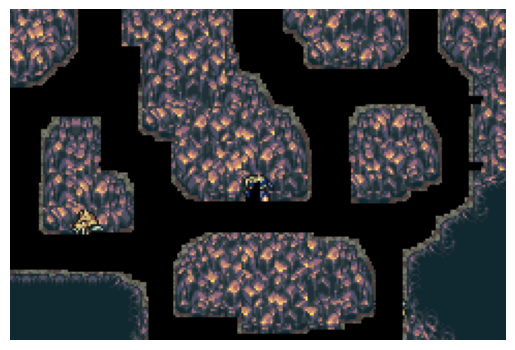

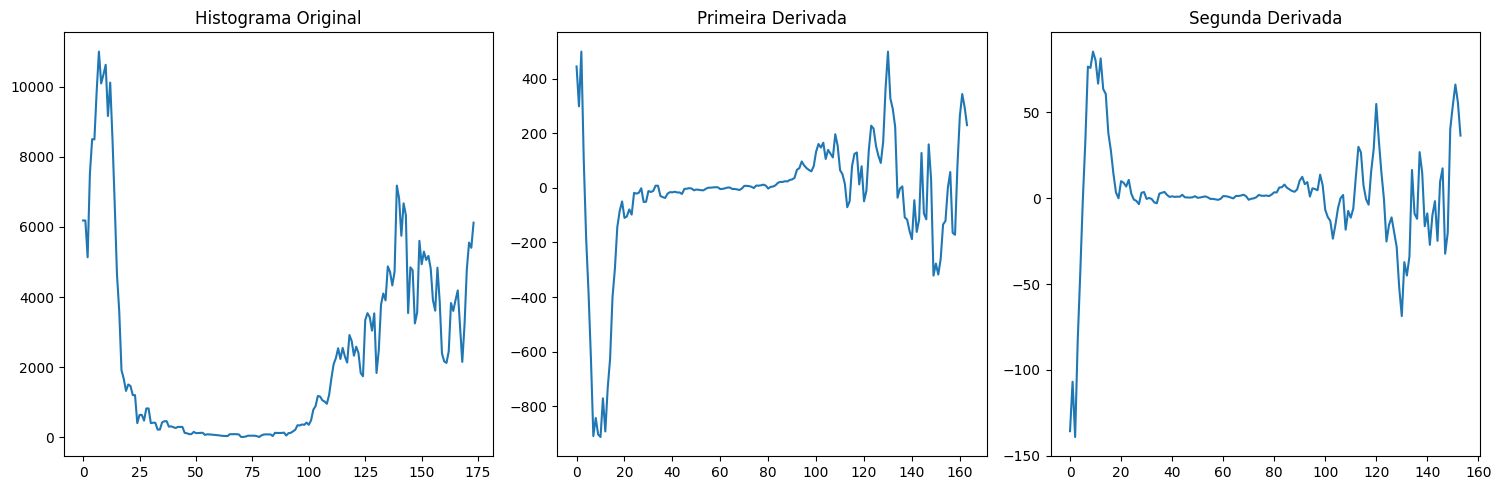

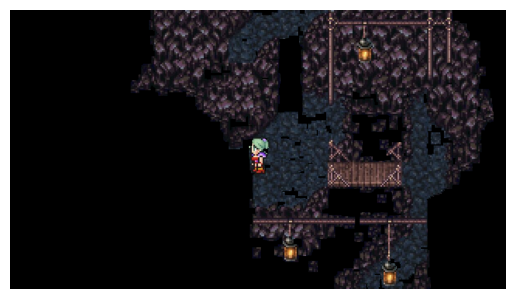

In [75]:
dicionario = {
    'Planicie': 'FFVI\\Maps\\planicie.jpg',
    'Planicie2': 'FFVI\\Maps\\fabrica.jpg',
    'Planicie3': 'FFVI\\Maps\\planicie3.jpg',
    'CavernaExt': 'FFVI\\Maps\\caverna_exterior.jpg',
    'CavernaInt': 'FFVI\\Maps\\caverna_interior.jpg',
    'CavernaInt2': 'FFVI\\Maps\\caverna_interior2.jpg',
    'CavernaInt3': 'FFVI\\Maps\\caverna_interior3.jpg',
}

for i in dicionario.values():
    original_image = Image.open(i)
    cv2_img = np.array(original_image)
    find_path(cv2_img)